# This is for P_FEM

[ 0.         -0.72769978  0.40423312  0.19511945 -0.00205436 -0.04685458]
[ 0.         -0.72769978  0.40423312  0.19511945 -0.00205436  0.        ]
rhs [ 0.         -0.72769978  0.40423312  0.19511945 -0.00205436  0.        ]
u_ [ 0.          0.97020703 -0.86658892  0.53896139 -0.16839799  0.        ]
phi [[ 0.5         0.4         0.3         0.2         0.1         0.        ]
 [ 0.5         0.6         0.7         0.8         0.9         1.        ]
 [-0.61237244 -0.58787754 -0.51439285 -0.39191836 -0.22045408  0.        ]
 [-0.         -0.15178933 -0.26563132 -0.30357866 -0.22768399  0.        ]
 [ 0.23385359  0.17959955  0.0392874  -0.11973304 -0.18521204  0.        ]
 [ 0.          0.13847979  0.16749945  0.04887522 -0.11302395  0.        ]]
u [ 0.21905862  0.2551229  -0.29870062 -0.04234956  0.10686058  0.03457576]


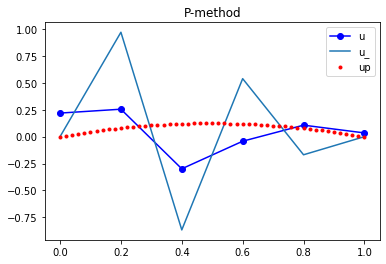

In [5]:
# %%

import numpy as np
from sympy import *
import sympy as sp
from scipy.special import roots_legendre
from sympy import *
import scipy.linalg as la
import matplotlib.pyplot as plt
import copy


def Legendre(x=np.linspace(-1, 1, 100), p=5):

    if p == 0:
        return 1
    elif p == 1:
        return x

    else:
        return ((2*p-1)*x*Legendre(x, p-1)+(1-p)*Legendre(x, p-2))/p


def Hierarchical(x=np.linspace(0, 1, 3), p=5):
    if p == 0:
        return (1-x)/2, np.zeros_like(x)-0.5
    elif p == 1:
        return (1+x)/2, np.zeros_like(x)+0.5
    else:
        return 1/np.sqrt(4*p-2)*(Legendre(x, p)-Legendre(x, p-2)), np.sqrt(p-1/2)*(Legendre(x, p-1))


def G_integrate(u, x, N=3, scale=(0, 1)):
    N = N  # 取3个样本点
    a = scale[0]  # 积分上下限
    b = scale[1]
    x, w = roots_legendre(N)
    # print(x)

    xp = x*(b-a)/2+(b+a)/2
    wp = w*(b-a)/2

    s = 0
    for i in range(N):
        s += wp[i]*u(xp[i])
    return s


def fem1d_pmethod(f, d2f, s=3, p=2):
    #
    #  Define the mesh, N+1 points between A and B.
    #  These will be X[0] through X[N].
    #
    a = 0.0
    b = 1.0
    x = np.linspace(a, b, p+1)
#
#  Set a 3 point quadrature rule on the reference interval [-1,1].
#
    q_num = p+1

    xg, wg = roots_legendre(q_num)

#
#  Compute the system matrix A and right hand side RHS.
    '''
    Quesstion 1. In p-FEM, how to calculate the K matrix, I don't know what's that size of the K matrix.
    '''
    K = np.zeros((p + 1, p + 1))
    F = np.zeros(p + 1)
    


    for q in range(q_num):
        xl = x[0]
        xr = x[-1]
        xq = ((1.0 - xg[q]) * xl + (1.0 + xg[q]) * xr) / 2.0
        wq = wg[q] * (xr - xl) / 2.0

        for i in range(p+1):
            phii, phiix = Hierarchical(xq, i)
            F[i] += wq * phii * d2f(xq)

            for j in range(p+1):
                phij, phijx = Hierarchical(xq, j)
                Kij = phii * phij + phiix * phijx
                K[i, j] += Kij * wq
                """
                Question 2: How to see the boundary condition in the F (or K), in this code, I set the Dirichlet BC in F 
                """

    K[0, 0] = 1.0
    K[0, 1:] = 0.0 
    F[0] = f(x[0])
    print(F)
#
#  Modify the linear system to enforce the right boundary condition.
#
    K[-1, -1] = 1.0
    K[-1, 0:-1] = 0.0
    F[-1] = f(x[-1])

    print(F)

    print('rhs', F)
#  Solve the linear system.
#
    u_ = la.solve(K, -F)
    print('u_', u_)
    # plt.plot(u_)
    phi = []
    for i in range(p+1):
        phi.append(Hierarchical(x, i)[0])
    phi = np.array(phi)
    
    # phi[0] = f(x[0])
    # phi[p] = f(x[-1])
    """
    Question 3: I think in the final numarical solution, the u = {phi} * {u_}, which u_ is gotten by solving K & F
    """
    u = np.dot(phi, u_.T)
    print('phi', phi)
    print('u', u)

    # plt.show()


#  Evaluate the exact solution at the nodes.

    uex = np.zeros(p + 1)
    for i in range(0, p + 1):
        uex[i] = f(x[i])
    err = []
    for i in range(0, p + 1):
        err.append(abs(uex[i] - u[i]))
        #print('  %4d  %14.6g  %14.6g  %14.6g' % (i, u[i], uex[i], err))

#  Plot the computed solution and the exact solution.
#  Evaluate the exact solution at enough points that the curve will look smooth.

    npp = 51
    xp = np.linspace(a, b, npp)
    up = np.zeros(npp)
    for i in range(0, npp):
        up[i] = f(xp[i])

    # plt.plot(x, u, 'bo-', xp, up, 'r.')
    filename = 'fem1d.png'
    # plt.savefig(filename)
    # plt.show()

    # plt.figure()
    plt.plot(x, u, 'bo-', label='u')
    plt.plot(x, u_, '', label='u_')
    plt.plot(xp, up, 'r.', label='up')
    plt.title('P-method')
    plt.legend()
    plt.show()
    # print(xp)

    return err, u, up


def exact_fn(x, a=0.5, xb=0.2):

    value = (1 - x) * (np.arctan(a * (x - xb)) + np.arctan(a*xb))
    # value = x * ( 1 - x ) * np.exp ( x )
    return value


def rhs_fn(x, a=0.5, xb=0.2):  # PDE

    B = x-xb
    value = -2*(a+a**3*B*(B-x+1))/(a**2*B**2+1)**2
    # value = -x * ( x + 3 ) * np.exp ( x )
    return value


if __name__ == "__main__":
    x = symbols("x")
    # print(Hierarchical(x))
    a = 0.5
    xb = 0.2
    # err, u, up = fem1d_linear(exact_fn, rhs_fn, 6)
    err, u, up = fem1d_pmethod(exact_fn, rhs_fn, s=5, p=5)
    # print(err)


# This is for H-FEM

[ 0.         -0.29115957 -0.3253275   0.        ]
[[ 3.  0.  0.  0.]
 [-3.  6. -3.  0.]
 [ 0. -3.  6. -3.]
 [ 0.  0.  0.  3.]]


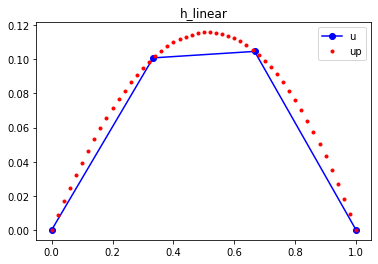

7.575177215857087e-09


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la
import time

def linear(i_local, xq, xl, xr):
  if (i_local == 0):
    phi = (xq - xr) / (xl - xr)
    dphi = 1 / (xl - xr)
  else:
    phi = (xq - xl) / (xr - xl)
    dphi = 1 / (xr - xl)

  return phi, dphi



def fn(x):

    value = (1 - x) * (np.arctan(a * (x - xb)) + np.arctan(a*xb))
    # value = x * ( 1 - x ) * np.exp ( x )
    return value


def d2fn(x):  # PDE

    B = x-xb
    value = -2*(a+a**3*B*(B-x+1))/(a**2*B**2+1)**2
    # value = -x * ( x + 3 ) * np.exp ( x )
    return value

def h_linear(f, d2f, n=1):
    #
    #  Define the mesh, N+1 points between A and B.
    #  These will be X[0] through X[N].
    #
    a = 0.0
    b = 1.0
    x = np.linspace(a, b, n+1)
    F = np.zeros(n+1)
    K = np.zeros((n+1, n+1))
#
#  Set a 3 point quadrature rule on the reference interval [-1,1].
#
    q_num = 3

    xg, wg = roots_legendre(q_num)
    for elem in range(n):

      xl = x[elem]
      xr = x[elem+1]
      

      for q in range(0, q_num):
            #
            #  Map XG and WG from [0,1] to
            #      XQ and WQ in [XL,XR].
            #
            # xq = ((1.0 - xg[q]) * xl + (1.0 + xg[q]) * xr) / 2.0
            # wq = wg[q]# * (xr - xl) / 4.0
            # xq = xl + xg[q] * (xr - xl)/2
            # wq = wg[q]
            xq = (xr - xl) / 2 * xg[q] + (xr + xl) / 2
            wq = wg[q]*(xr - xl) / 2

            for i_local in range(0, 2):
                i = i_local + elem

                phii, phiip = linear(i_local, xq, xl, xr)

                F[i] += wq * phii * d2f(xq)
#
#  Consider the J-th basis function PHI(J,X) and its derivative PHI'(J,X).
#  (It turns out we don't need PHI for this particular problem, only PHI')
#
                for j_local in range(0, 2):
                    j = j_local + elem
                    phijp = linear(j_local, xq, xl, xr)[1]

                    K[i][j] += wq * phiip * phijp


    # K[0, 0] = 1.0
    K[0, 1:n+1] = 0.0 
    F[0] = fn(x[0])
    """
    Question 4: How to set the BC in h-FEM. If K[0, 1:n+1] = 0.0 is removed, the matrix is singular in some element numbers.
    Question 5: The BC in F is also strange. In the deriative, the boundary term should be the Neumann BC, but in the code, the BC is the 
    value of f(x). But the result has very low error. 
    """
    
#
#  Modify the linear system to enforce the right boundary condition.
#
    # K[n, n] = 1.0
    K[n, 0:n] = 0.0
    F[n] = fn(x[n])
    print(F)
    print(K)
    uh = la.solve(K, -F)

    uex = np.zeros(n + 1)
    for i in range(0, n + 1):
        uex[i] = f(x[i])
    err = []
    for i in range(0, n + 1):
        err.append(abs(uex[i] - uh[i]))
#
#  Plot the computed solution and the exact solution.
#  Evaluate the exact solution at enough points that the curve will look smooth.
#
    npp = 51
    xp = np.linspace(a, b, npp)
    up = np.zeros(npp)
    for i in range(0, npp):
        up[i] = f(xp[i])

    plt.plot(x, uh, 'bo-', label='u')
    plt.plot(xp, up, 'r.', label='up')
    plt.title('h_linear')
    plt.legend()
    plt.show()

    return np.linalg.norm(err), u, up


a = 0.5
xb = 0.8
err, u, up = h_linear(fn, d2fn, 3)
print(err)


# Ignore this

In [ ]:
# %%

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la
import time


def fem1d_linear(f, d2f, n=13):
    #
    #  Define the mesh, N+1 points between A and B.
    #  These will be X[0] through X[N].
    #
    a = 0.0
    b = 1.0
    x = np.linspace(a, b, n + 1)
#
#  Set a 3 point quadrature rule on the reference interval [-1,1].
#
    q_num = 3

    # xg = np.array((
    # -0.774596669241483377035853079956,
    # 0.0,
    # 0.774596669241483377035853079956))

    # wg = np.array((
    #     5.0 / 9.0,
    #     8.0 / 9.0,
    #     5.0 / 9.0))
    xg, wg = roots_legendre(q_num)

#
#  Compute the system matrix A and right hand side RHS.
#
    A = np.zeros((n + 1, n + 1))
    rhs = np.zeros(n + 1)
#
#  Look at element E: (0, 1, 2, ..., N-1).
#
    for e in range(0, n):

        xl = x[e]
        xr = x[e+1]
#
#  Consider quadrature point Q: (0, 1, 2 ) in element E.
#
        for q in range(0, q_num):
            #
            #  Map XG and WG from [0,1] to
            #      XQ and QQ in [XL,XR].
            #
            # xq = xl + xg[q] * (xr - xl)
            # wq = wg[q] * (xr - xl)
            # xq = xl + (xg[q] + 1.0) * (xr - xl) / 2.0
            # wq = wg[q] * (xr - xl) / 2.0
            xq = ((1.0 - xg[q]) * xl + (1.0 + xg[q]) * xr) / 2.0
            wq = wg[q] * (xr - xl) / 2.0
#
#  Consider the I-th test function PHI(I,X) and its derivative PHI'(I,X).
#
            for i_local in range(0, 2):
                i = i_local + e

                if (i_local == 0):
                    phii = (xq - xr) / (xl - xr)
                    phiip = 1 / (xl - xr)
                else:
                    phii = (xq - xl) / (xr - xl)
                    phiip = 1 / (xr - xl)

                rhs[i] = rhs[i] + wq * phii * d2f(xq)
#
#  Consider the J-th basis function PHI(J,X) and its derivative PHI'(J,X).
#  (It turns out we don't need PHI for this particular problem, only PHI')
#
                for j_local in range(0, 2):
                    j = j_local + e

                    if (j_local == 0):
                        phijp = 1 / (xl - xr)
                    else:
                        phijp = 1 / (xr - xl)
                    #print(wq * phiip * phijp)

                    A[i][j] = A[i][j] + wq * phiip * phijp
    print(rhs)
#
#  Modify the linear system to enforce the left boundary condition.
#
    A[0, 0] = 1.0
    A[0, 1:n+1] = 0.0
    rhs[0] = f(x[0])
    
#
#  Modify the linear system to enforce the right boundary condition.
#
    A[n, n] = 1.0
    A[n, 0:n] = 0.0
    rhs[n] = f(x[n])

    print('A', A)
    print('_-----------------------\n', rhs)
#  Solve the linear system.
#
    u = la.solve(A, -rhs)

#
#  Evaluate the exact solution at the nodes.
#
    uex = np.zeros(n + 1)
    for i in range(0, n + 1):
        uex[i] = f(x[i])
    err = []
    for i in range(0, n + 1):
        err.append(abs(uex[i] - u[i]))
        # print('  %4d  %14.6g  %14.6g  %14.6g' % (i, u[i], uex[i], err))
#
#  Plot the computed solution and the exact solution.
#  Evaluate the exact solution at enough points that the curve will look smooth.
#
    npp = 51
    xp = np.linspace(a, b, npp)
    up = np.zeros(npp)
    for i in range(0, npp):
        up[i] = f(xp[i])

    # plt.plot(x, u, 'bo-', xp, up, 'r.')
    filename = 'fem1d.png'
    plt.savefig(filename)
    # plt.show()

    # plt.figure()
    plt.plot(x, u, 'bo-', label='u')
    plt.plot(xp, up, 'r.', label='up')
    plt.title('h_linear')
    plt.legend()
    plt.show()
    # print(xp)

    return err, u, up


def exact_fn(x):

    value = (1 - x) * (np.arctan(a * (x - xb)) + np.arctan(a*xb))
    # value = x * ( 1 - x ) * np.exp ( x )
    return value


def rhs_fn(x):  # PDE

    B = x-xb
    value = -2*(a+a**3*B*(B-x+1))/(a**2*B**2+1)**2
    # value = -x * ( x + 3 ) * np.exp ( x )
    return value


if __name__ == '__main__':
    a = 0.5
    xb = 0.2
    # for i in [6, 11, 21, 41]:
    #     err, u, up = fem1d_linear(exact_fn, rhs_fn, i)
    err, u, up = fem1d_linear(exact_fn, rhs_fn, 2)
    #print(err)
    # plt.plot(err)
# %%


